# Identificación de la respuesta al impulso

Se identifica un modelo ARMAX entrando con
- impulso
- escalón y luego derivando (restando muestras sucesivas) 

Se observa que el segundo método brinda una mejor predicción de la respuesta al escalón

In [ ]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as signal

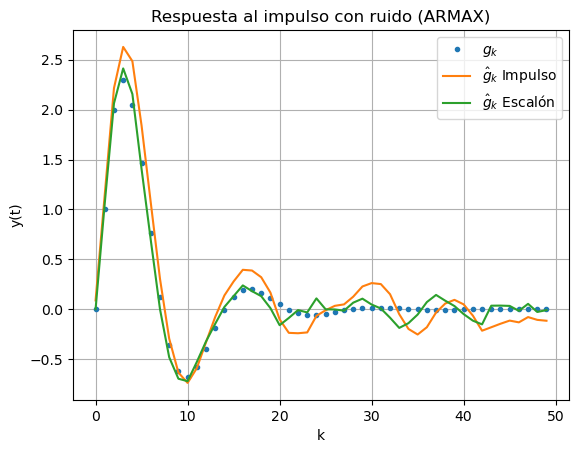

In [60]:
# Amplitud del impulso
alpha = 2

# Parámetros ARMAX ejemplo
A = [1, -1.5, 0.7]
B = [0, 1, 0.5]
C = [1]

# Entrada impulso
N = 50
u = np.zeros(N)
u[0] = alpha  # impulso en t=0

# Entrada escalón
ue = alpha*np.ones(N)

# Ruido blanco
np.random.seed(0)
e = np.random.normal(0, 0.1, N)

# Filtro de la entrada
y_u = signal.lfilter(B, A, u)
y_ue = signal.lfilter(B, A, ue)

# Filtro del ruido
y_e = signal.lfilter(C, A, e)

# Salida total
y = y_u + y_e
ye = y_ue + y_e

g_hat_e = np.concatenate([[0],np.diff(ye)])/alpha
g_hat = y/alpha
g = y_u/alpha

# Graficar
plt.plot(g,'.', label='$g_k$')
plt.plot(g_hat, label='$\\hat{{g}}_k$ Impulso')
plt.plot(g_hat_e, label='$\\hat{{g}}_k$ Escalón')
plt.xlabel("k")
plt.ylabel("y(t)")
plt.legend()
plt.title("Respuesta al impulso con ruido (ARMAX)")
plt.grid()
plt.show()


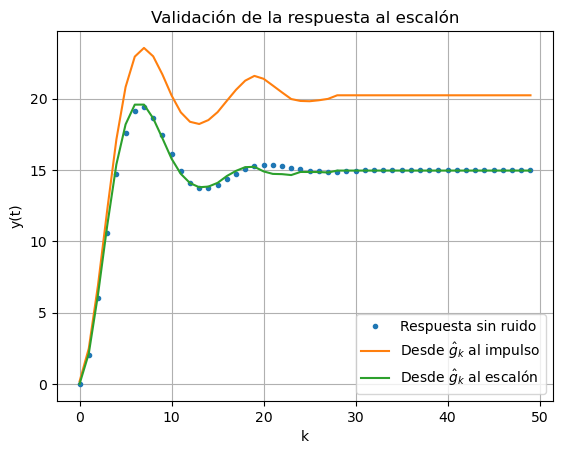

In [65]:
#ye_hat = np.cumsum(g_hat) * alpha
#yee_hat = np.cumsum(g_hat_e) * alpha
N_filtro = 30
ye_hat = signal.lfilter(g_hat[0:N_filtro-1],[1],ue)
yee_hat = signal.lfilter(g_hat_e[0:N_filtro-1],[1],ue)

plt.plot(y_ue,'.',label='Respuesta sin ruido')
plt.plot(ye_hat,label='Desde $\\hat{{g}}_k$ al impulso')
plt.plot(yee_hat,label='Desde $\\hat{{g}}_k$ al escalón')
plt.title("Validación de la respuesta al escalón")
plt.xlabel("k")
plt.ylabel("y(t)")
plt.grid()
plt.legend()
